# Kalman Filter Example with a chaotic system

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Simulating the Lorenz system

In [2]:
# Lorenz system equations
def lorenz(t, xyz, sigma, rho, beta):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Parameters`
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Initial conditions
initial_xyz = np.array([3, 3, 3])

# Time span
t_span = (0, 35)
t_eval = np.arange(t_span[0], t_span[1], 0.01)


np.random.seed(100)

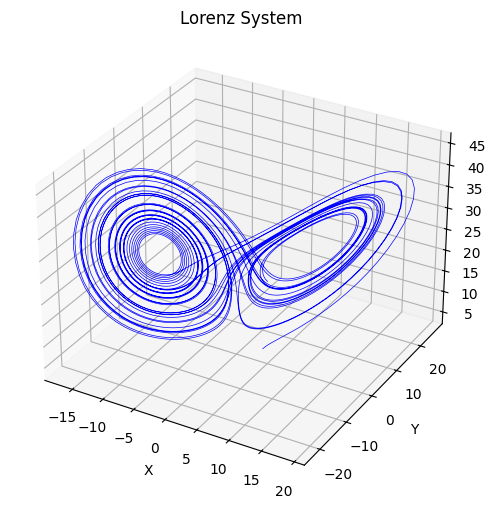

In [3]:
# Solve the system
sol = solve_ivp(lorenz, t_span, initial_xyz, args=(sigma, rho, beta), t_eval=t_eval)

true_sol = sol.y

# Plot the results
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(true_sol[0], true_sol[1], true_sol[2], 'b-', linewidth=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System')
plt.show()


## Sensitive dependence on Initial Condition

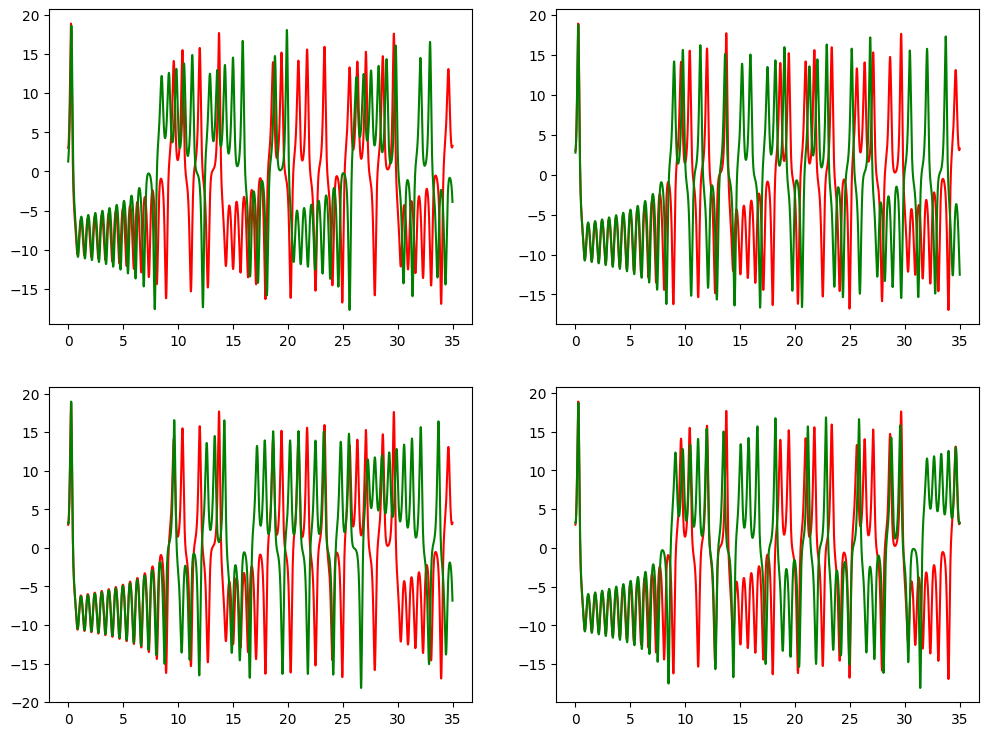

In [4]:
noise_level = 1

plt.figure(figsize=(12,9))

for j in range(4):
    noisy_initial_xyz = initial_xyz + np.random.normal(0, noise_level, size = (3))

    # Solve the system with noisy IC
    sol = solve_ivp(lorenz, t_span, noisy_initial_xyz, args=(sigma, rho, beta), t_eval=t_eval)

    noisy_sol = sol.y

    plt.subplot(2,2,j+1)
    plt.plot(t_eval, true_sol[0], color='r', label = 'true x(t)')
    plt.plot(t_eval, noisy_sol[0], color='g', label = 'simulated x(t)')
    

## Noisy observations/measurements

In [5]:
# Covariance matrices
Q = np.eye(3) *  0.001 # Process noise covariance
R = np.eye(3) * 4 # Measuremet noise covariance


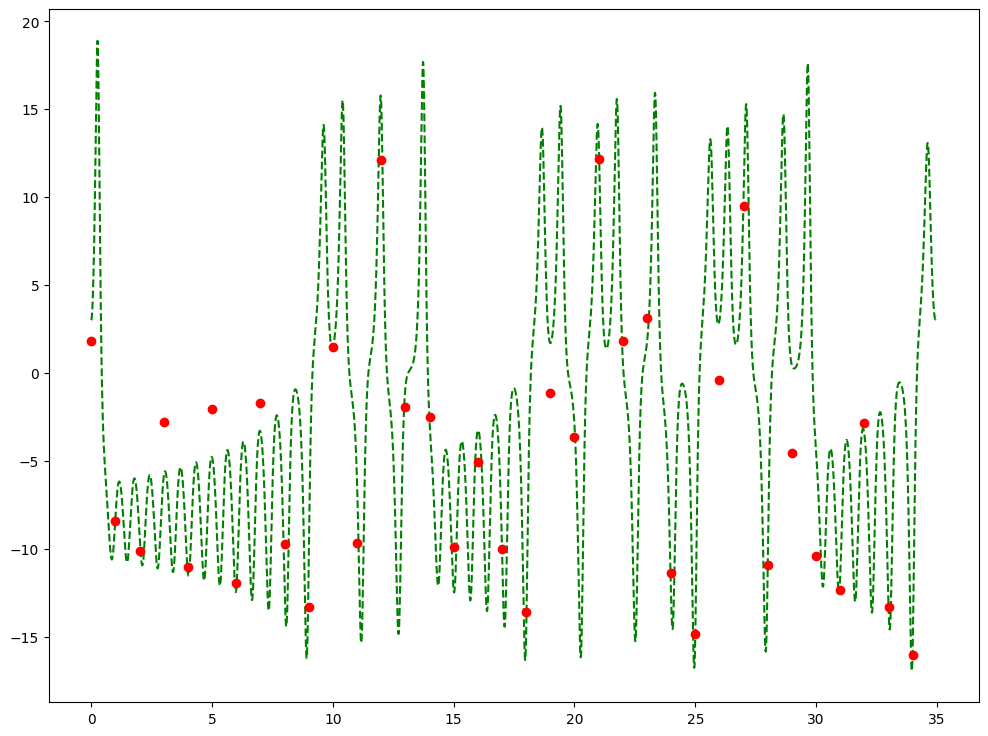

In [6]:
#Measurement width determines how far measurement points are spread across in time.
measure_width = 100

t_measure = t_eval[::measure_width]

measured_sol = true_sol[:,::measure_width] 
#Adding measurement noise to true state
measured_sol = measured_sol + np.random.multivariate_normal([0,0,0], R, size = measured_sol[0].shape).transpose()

plt.figure(figsize=(12,9))
plt.plot(t_eval, true_sol[0], c= 'g', ls='--', label = 'true y(t)')
plt.plot(t_measure, measured_sol[0], 'ro', label = 'measured y(t)')


# DA: Kalman Filtering

In [7]:
# Define Jacobian of the Lorenz system
def lorenz_jacobian(state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    return np.array([
        [-sigma, sigma, 0],
        [rho - z, -1, -x],
        [y, x, -beta]
    ])

In [8]:
def solver_jac_finder(RHS, t_span, IC, args, t_eval, dx=0.01):
    """
    Explain what this function is doing, and explain what is a more accurate way of doing this. 
    """
    assert abs(dx) > 1.e-10, "dx value is too small"
    dim = len(IC)
    solver_jac = 0*np.eye(dim)
    for i in range(dim):
        h = np.zeros(dim)
        h[i] = dx
        solver_jac[:,i] = (solve_ivp(RHS, t_span, IC + h, args =args, t_eval=t_eval).y [:,-1] -
                     solve_ivp(RHS, t_span, IC, args =args, t_eval=t_eval).y [:,-1])/dx
    return solver_jac
            

In [9]:
kalman_sol_list = []
# ic_corrected = measured_sol[:,0]
ic_corrected = true_sol[:,0]

t_eval_list = []

P = R

#This is where we iteratively apply Kalman filter at each measurement step.
for ind in range(len(t_measure)-1):
    t_span = (t_measure[ind], t_measure[ind+1])
    t_eval_short = np.linspace(t_span[0], t_span[1], measure_width + 1 )

    # Prediction step
    sol = solve_ivp(lorenz, t_span, ic_corrected, args = (sigma, rho, beta), t_eval = t_eval_short)
    calc_sol = sol.y

    jacob_prev = solver_jac_finder(lorenz, t_span, ic_corrected, args = (sigma, rho, beta), t_eval = t_eval_short)

    P = np.matmul(jacob_prev, np.matmul(P, jacob_prev.transpose())) + Q

    try:
        K_gain = np.matmul(P, np.linalg.inv(P+R))
    except Exception as e:
        if str(e) == "Singular matrix":
            K_gain = np.eye(3)
        else:
            raise
    ic_model = calc_sol[:, -1]
    ic_measured = measured_sol[:, ind+1]
    #Innovation step
    ic_corrected = ic_model + np.matmul(K_gain, ic_measured - ic_model)

    kalman_sol_list.append(calc_sol[:,:-1])
    t_eval_list.append(t_eval_short[:-1])
    

## Plotting Kalman-corrected solution vs true solution

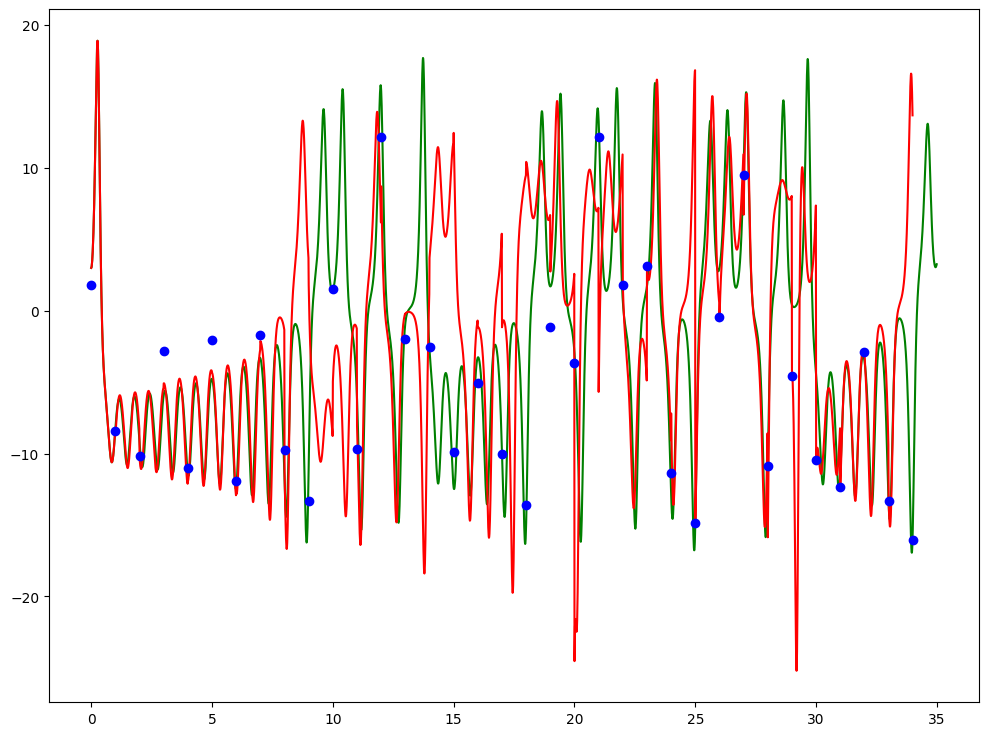

In [10]:
plt.figure(figsize=(12,9))
plt.plot(t_eval, true_sol[0,:], 'g')
plt.plot(np.concatenate(t_eval_list), np.concatenate(kalman_sol_list, axis=1)[0], 'r-')
plt.plot(t_measure, measured_sol[0], 'bo', label = 'measured y(t)')

# for t_eval_, sol_ in zip(t_eval_list, kalman_sol_list):
#     plt.plot(t_eval_, sol_[1], 'r')

In [11]:
n = 10

In [12]:
n+10

20